# Machine Learning Exercise 14

# CNN Ensembles - CIFAR10 



## Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPool2D, Input, BatchNormalization
from keras import regularizers
from keras import optimizers
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.1
Found GPU at: /device:GPU:0


## Load data

Load training data from Keras library




In [3]:
def load_cifar10():
    # load data
    (Xtrain,Ytrain), (Xtest, Ytest) = tf.keras.datasets.cifar10.load_data()
    print(Ytrain.shape)
    # get information
    ninput = Xtrain.shape[0]
    imgsize = (Xtrain.shape[1], Xtrain.shape[2])
    input_shape = (Xtrain.shape[1], Xtrain.shape[2], Xtrain.shape[3])
    ntest = Xtest.shape[0]
    num_classes = np.max(np.unique(Ytrain)) + 1
    print("Training input %s" %str(Xtrain.shape))
    print("Training output %s" %str(Ytrain.shape))
    print("Test input %s" %str(Xtest.shape))
    print("Test output %s" %str(Ytest.shape))
    print("Input shape: %s" %str(input_shape))
    print("Number of classes: %d" %num_classes)

    # normalize input to [0,1]
    Xtrain = Xtrain / 255.0
    Xtest = Xtest / 255.0
    
    # Transform output to one-out-of-n encoding
    Ytrain = tf.keras.utils.to_categorical(Ytrain, num_classes)
    Ytest = tf.keras.utils.to_categorical(Ytest, num_classes)
    
    return [Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes]

[Xtrain,Ytrain,Xtest,Ytest,input_shape,num_classes] = load_cifar10()

170498071/170498071 [==============================] - 10s 0us/step
(50000, 1)
Training input (50000, 32, 32, 3)
Training output (50000, 1)
Test input (10000, 32, 32, 3)
Test output (10000, 1)
Input shape: (32, 32, 3)
Number of classes: 10


## Show random image



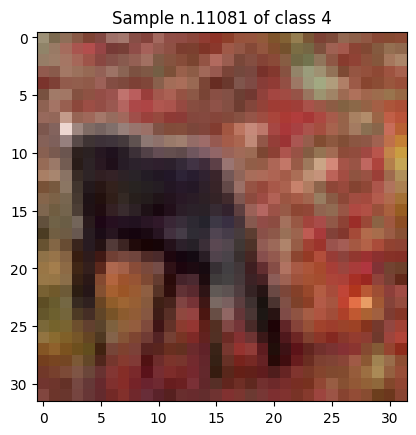

In [16]:
i = random.randrange(0,Xtrain.shape[0])
image = Xtrain[i]
image = np.array(image, dtype='float')

label = Ytrain[i].argmax()  # categorical from one-hot-encoding

plt.title(F"Sample n.{i} of class {label}")
plt.imshow(image, cmap='gray')
plt.show()

## CNN ensemble model


In [17]:
# single model
def CNN(input_shape, num_classes, base_width=16, depth=4):
    
    inputs = Input(input_shape)
    
    image_size = input_shape[0]
    filters = base_width
    kernel_size = 3
    # feature extractor
    for i in range(depth):
        if i == 0:
            x = Conv2D(filters=filters,
                       kernel_size = kernel_size,
                       activation="relu",
                       strides=1,
                       padding="same")(inputs)
        else:
            x = Conv2D(filters=filters,
                       kernel_size = kernel_size,
                       activation="relu",
                       strides=1,
                       padding="same")(x)
        x = MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid")(x)
        filters *= 2
    
    x = Flatten()(x) 
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# ensemble model
def Ensemble(ens_dim, input_shape, num_classes, base_width=16, depth=4):
  inputs = Input(shape=input_shape)
  
  learners = [CNN(input_shape,
                  num_classes,
                  base_width,
                  depth) for _ in range(ens_dim)]
  
  outputs = [learners[i](inputs) for i in range(ens_dim)]
  
  ensemble_model = Model(inputs, outputs, name="ensemble_model")
  optimizer = 'adam'
  # an independent loss for each model
  losses = ["categorical_crossentropy" for _ in range(ens_dim)]
  ensemble_model.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])
  return ensemble_model


# create the ensemble model
ens_dim = 3
model = Ensemble(ens_dim, input_shape, num_classes)
model.summary()

# single model summary
model.get_layer(index=-1).summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           102570      ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 10)           102570      ['input_1[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 10)           102570      ['input_1[0][0]']                
                                                                                     

# Train setup

In [18]:
def test_accuracy(model, history):
    # accuracy
    ind_test_acc = []
    for key in history.history.keys():
      if ("val" in key) and ("accuracy" in key):
        ind_test_acc.append(history.history[key][-1])
    print("Single models test accuracy: ", ind_test_acc)

    # ensemble test accuracy
    preds = np.array(model.predict(Xtest))
    # average over the ensemble
    preds_ens = np.mean(preds, axis=0)
    ens_test_acc = accuracy_score(np.argmax(Ytest, axis=-1), np.argmax(preds_ens, axis=-1))
    print("Ensemble test accuracy: ", ens_test_acc)

    return ind_test_acc, ens_test_acc


history = tf.keras.callbacks.History()
ind_test_accuracy = []
ens_test_accuracy = []

## Train

In [19]:
epochs = 5
for _ in range(epochs):
    model.fit(Xtrain, [Ytrain for _ in range(ens_dim)], batch_size=32, epochs=1, callbacks=[history], validation_data = (Xtest,[Ytest for _ in range(ens_dim)]))

    iacc, eacc = test_accuracy(model, history)
    ind_test_accuracy.append(iacc)
    ens_test_accuracy.append(eacc)

1563/1563 [==============================] - 33s 15ms/step - loss: 4.6311 - model_loss: 1.5515 - model_1_loss: 1.5548 - model_2_loss: 1.5248 - model_accuracy: 0.4337 - model_1_accuracy: 0.4294 - model_2_accuracy: 0.4425 - val_loss: 3.6146 - val_model_loss: 1.2184 - val_model_1_loss: 1.2215 - val_model_2_loss: 1.1746 - val_model_accuracy: 0.5704 - val_model_1_accuracy: 0.5579 - val_model_2_accuracy: 0.5779
Single models test accuracy:  [0.5703999996185303, 0.5579000115394592, 0.5778999924659729]
313/313 [==============================] - 2s 4ms/step
Ensemble test accuracy:  0.587
1563/1563 [==============================] - 24s 15ms/step - loss: 3.4869 - model_loss: 1.1721 - model_1_loss: 1.1684 - model_2_loss: 1.1465 - model_accuracy: 0.5819 - model_1_accuracy: 0.5845 - model_2_accuracy: 0.5910 - val_loss: 3.1004 - val_model_loss: 1.0466 - val_model_1_loss: 1.0420 - val_model_2_loss: 1.0118 - val_model_accuracy: 0.6294 - val_model_1_accuracy: 0.6270 - val_model_2_accuracy: 0.6434
Singl

## Evaluate the model

## Compare single networks with ensemble


In [20]:
print(ind_test_accuracy)
print(ens_test_accuracy)

[[0.5703999996185303, 0.5579000115394592, 0.5778999924659729], [0.6294000148773193, 0.6269999742507935, 0.6434000134468079], [0.6599000096321106, 0.6833999752998352, 0.6818000078201294], [0.6818000078201294, 0.7042999863624573, 0.7024999856948853], [0.7031999826431274, 0.7103999853134155, 0.6988999843597412]]
[0.587, 0.6572, 0.702, 0.7307, 0.7318]


Text(0.5, 0, 'epoch')

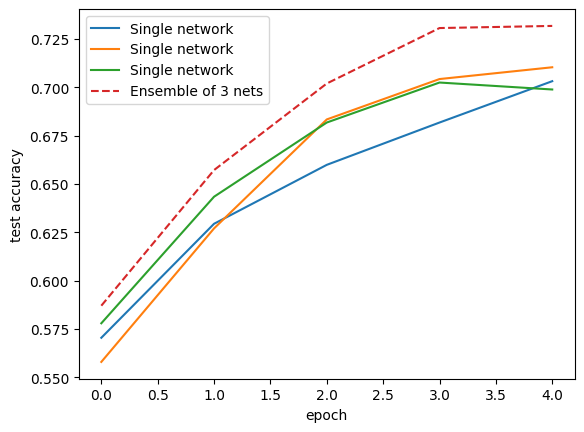

In [21]:
plt.plot(ind_test_accuracy, label="Single network")
plt.plot(ens_test_accuracy, linestyle="--", label="Ensemble of {} nets".format(ens_dim))
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')

# Home Exercises

**Question 1** 

Evaluate the performance of ensembles varying the number of base members.

In [22]:
# create the ensemble model
ens_dim = 5
model = Ensemble(ens_dim, input_shape, num_classes)
model.summary()

# single model summary
model.get_layer(index=-1).summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_3 (Functional)           (None, 10)           102570      ['input_5[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 10)           102570      ['input_5[0][0]']                
                                                                                                  
 model_5 (Functional)           (None, 10)           102570      ['input_5[0][0]']                
                                                                                     

In [23]:
history = tf.keras.callbacks.History()
ind_test_accuracy = []
ens_test_accuracy = []
epochs = 5

for _ in range(epochs):
    model.fit(Xtrain, [Ytrain for _ in range(ens_dim)], batch_size=32, epochs=1, callbacks=[history], validation_data = (Xtest,[Ytest for _ in range(ens_dim)]))

    iacc, eacc = test_accuracy(model, history)
    ind_test_accuracy.append(iacc)
    ens_test_accuracy.append(eacc)

1563/1563 [==============================] - 40s 24ms/step - loss: 7.7705 - model_3_loss: 1.5792 - model_4_loss: 1.5452 - model_5_loss: 1.5485 - model_6_loss: 1.5430 - model_7_loss: 1.5546 - model_3_accuracy: 0.4200 - model_4_accuracy: 0.4324 - model_5_accuracy: 0.4291 - model_6_accuracy: 0.4321 - model_7_accuracy: 0.4252 - val_loss: 6.0979 - val_model_3_loss: 1.2227 - val_model_4_loss: 1.1996 - val_model_5_loss: 1.2138 - val_model_6_loss: 1.2405 - val_model_7_loss: 1.2213 - val_model_3_accuracy: 0.5611 - val_model_4_accuracy: 0.5700 - val_model_5_accuracy: 0.5629 - val_model_6_accuracy: 0.5478 - val_model_7_accuracy: 0.5676
Single models test accuracy:  [0.5611000061035156, 0.5699999928474426, 0.5629000067710876, 0.5478000044822693, 0.5676000118255615]
313/313 [==============================] - 2s 7ms/step
Ensemble test accuracy:  0.5892
1563/1563 [==============================] - 42s 27ms/step - loss: 5.8411 - model_3_loss: 1.1691 - model_4_loss: 1.1697 - model_5_loss: 1.1645 - mode

Text(0.5, 0, 'epoch')

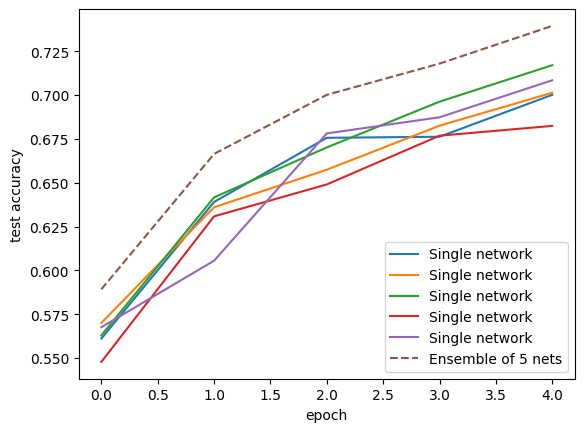

In [24]:
plt.plot(ind_test_accuracy, label="Single network")
plt.plot(ens_test_accuracy, linestyle="--", label="Ensemble of {} nets".format(ens_dim))
plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')